# Handling Time Series Data & Modeling with an Interaction Term
Analyzed Six Flags stock price time series data through November 2025 using Python to identify trends, volatility, and seasonality via differencing, rolling statistics, and resampling. Built a marketing mix regression with an interaction term to quantify how influencer and email spending jointly drive conversions and improve model performance.

## Part I: Working with Time Series Data

In [ ]:
# Import necessary functions to use
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

#### Pick any publicly-traded company that trades on the Nasdaq or the NYSE.
I selected Six Flags Entertainment Corporation Common Stock New (ticker symbol: FUN). I chose this company because its business operations are closely aligned with Lobster Land, and it offers a useful point of comparison. It is also interesting to see how a major attraction and theme park operator performs in the market and responds to industry conditions.

#### Go to the Nasdaq homepage: www.nasdaq.com. Enter your company’s ticker symbol in “Symbol Search” area near the top of your screen.

In [38]:
six_flags = pd.read_csv("data/six_flags_ytd.csv", index_col="Date", parse_dates=True)

In [39]:
six_flags.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2025-11-14,$14.60,4632733,$14.93,$15.11,$14.13
2025-11-13,$15.06,4082496,$16.40,$16.84,$15.04
2025-11-12,$16.15,6184328,$15.63,$16.55,$15.5665
2025-11-11,$15.44,7981932,$16.23,$16.245,$14.805
2025-11-10,$16.35,7033631,$17.91,$17.985,$16.22


#### Rename the ‘Close/Last’ column to ‘Close’

In [40]:
six_flags = six_flags.rename(columns={"Close/Last": "Close"})

#### Next, call the info() function on your dataset, and show your results.

In [41]:
six_flags.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2025-11-14 to 2024-11-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   249 non-null    object
 1   Volume  249 non-null    int64 
 2   Open    249 non-null    object
 3   High    249 non-null    object
 4   Low     249 non-null    object
dtypes: int64(1), object(4)
memory usage: 11.7+ KB


In [42]:
six_flags.describe()

,Volume
count,2.490000e+02
mean,2.667437e+06
std,2.392663e+06
min,3.633340e+05
25%,1.251373e+06
50%,2.139382e+06
75%,3.332256e+06
max,2.684338e+07


In [43]:
# Remove all dollar signs and change the data type to float
six_flags = six_flags.replace({'\$': ''}, regex=True)
six_flags = six_flags.astype({'Close': float, 'Open': float, 'High': float, 'Low': float})
six_flags.head()

,Close,Volume,Open,High,Low
Date,,,,,
2025-11-14,14.60,4632733,14.93,15.110,14.1300
2025-11-13,15.06,4082496,16.40,16.840,15.0400
2025-11-12,16.15,6184328,15.63,16.550,15.5665
2025-11-11,15.44,7981932,16.23,16.245,14.8050
2025-11-10,16.35,7033631,17.91,17.985,16.2200


In this step, I removed the dollar signs from the price columns and converted them into float values so the data can be analyzed properly. Once cleaned, the dataset is ready for any calculations or modeling.

#### Is this dataframe indexed by time values? How do you know this?
Yes, this dataframe is indexed by time. I can tell because the index is made up of dates (e.g. “2025-11-14,” “2025-11-13”), which indicates that each row is organized and labeled by a specific point in time rather than by a simple numeric index.

#### Visualize the entire time series.
#### First, just call .plot() on your dataframe object.

<Axes: xlabel='Date'>

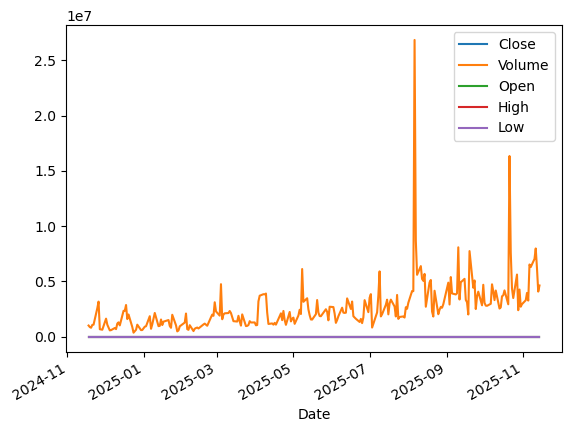

In [44]:
six_flags.plot()

##### Describe what you see here. Why is this a challeging graph to interpret? What would make it easier to understand?
This graph shows five stock metrics: Close, Volume, Open, High, and Low, plotted from November 2024 to November 2025. Each metric is shown as a different colored line, but the y-axis combines both price values and Volume, which reaches into over the millions units. Because the price-based metrics stay within a much smaller range, their lines appear compressed while Volume dominates the scale.

The graph is hard to interpret because the shared y-axis has to stretch to fit the huge Volume values, which makes the price lines look almost flat. It would be much easier to read if Volume had its own y-axis or subplot, and if the chart included clearer labels or a legend to show which line represents each metric.

#### Now, re-run the .plot() function, but this time, call that function on the ‘Close’ variable only.

<Axes: xlabel='Date'>

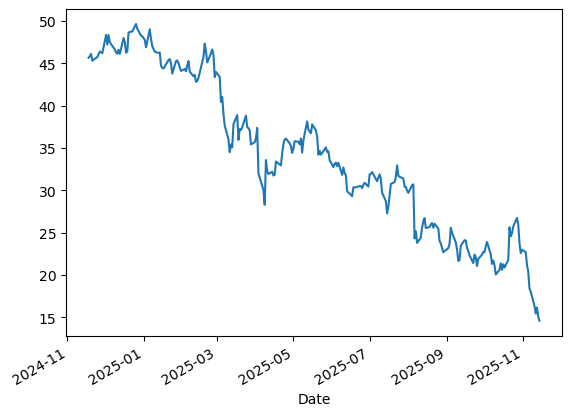

In [45]:
six_flags["Close"].plot()

##### Now, in a couple sentences, describe what you see. Why is this graph more easily interpretable than the one you plotted in the previous step?
When I only plot the ‘Close’ variable, the graph clearly shows a downward trend in closing prices over time, with a slight fluctuations. The line is clear easy to follow, making it simple to see how the stock’s value declined from November 2024 to November 2025. This graph is easier to interpret than the previous plot because it focuses on a single variable with a consistent scale. By removing Volume, the y-axis now matches the scale of the prices, making it easy to see how the closing price changes over time.

#### Re-plot the ‘Close’ variable, and add a horizontal line representing the average closing price for the year.

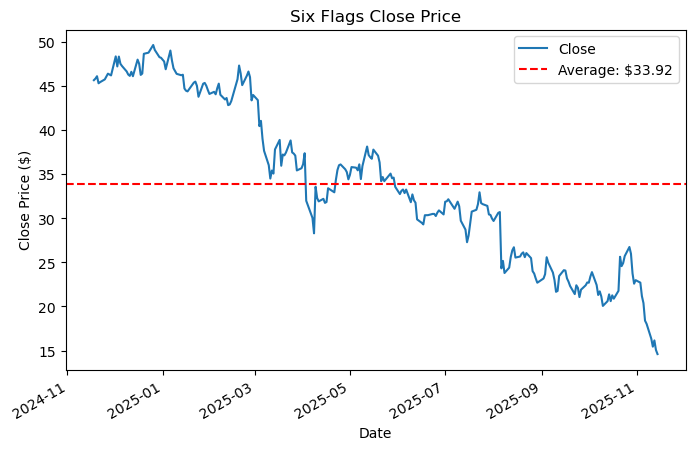

In [46]:
# Calculate average closing price
avg_close = six_flags["Close"].mean()

ax = six_flags["Close"].plot(figsize=(8, 5), title="Six Flags Close Price")
ax.axhline(y=avg_close, color='red', linestyle='--', label=f'Average: ${avg_close:.2f}')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price ($)")
ax.legend()
plt.show()

##### What does this line help you see more clearly?
Adding a horizontal line for the average closing price makes the graph much easier to read by providing a clear benchmark. In this case, the red dashed line at $33.92 shows that the stock spent most of the year below its average, especially in the second half. This also makes it easy to compare the stock’s daily movements to its overall trend, highlighting when it was consistently above or below the average. Therefore, it easy to spot long-term trends and periods of underperformance or outperformance.

#### Use the .diff() method to calculate the daily change in the ‘Close’ price, and store the result in a new column called 'daily_change'.

In [47]:
six_flags["daily_change"] = six_flags["Close"].diff()
six_flags.head()

,Close,Volume,Open,High,Low,daily_change
Date,,,,,,
2025-11-14,14.60,4632733,14.93,15.110,14.1300,NaN
2025-11-13,15.06,4082496,16.40,16.840,15.0400,0.46
2025-11-12,16.15,6184328,15.63,16.550,15.5665,1.09
2025-11-11,15.44,7981932,16.23,16.245,14.8050,-0.71
2025-11-10,16.35,7033631,17.91,17.985,16.2200,0.91


##### Plot the 'daily_change' variable.

<Axes: xlabel='Date'>

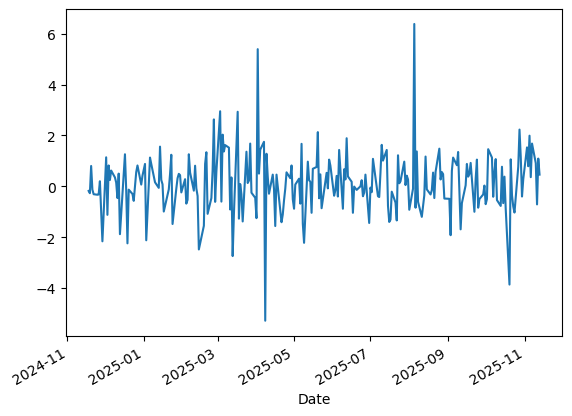

In [48]:
six_flags["daily_change"].plot()

##### What does this show that the original closing price plot did not?
For Six Flags, plotting the daily_change variable reveals the day-to-day volatility in the stock that the original closing price graph did not show. Instead of a smooth downward trend, the values oscillate around zero with both positive and negative spikes, highlighting short-term gains and losses. This makes it clear that Six Flags’ stock movement was more turbulent than the overall decline suggests, providing insight into its momentum and risk.

##### Do you notice any periods of unusually high or low movement?
Yes, there are periods of unusually high and low movement. For example, there’s a sharp upward spike followed closely by a steep drop around mid-2025, suggesting a possible earnings announcement or noticable event that quickly affected market reactions. These significant swings stand out clearly in the daily_change graph and would be difficult to detect in the original closing price plot. Such periods are critical for analysts to investigate further, as they may signal turning points or underlying volatility that affects investment decisions.

#### Plotting a subset of your data
##### Using a slice operation, plot the daily ‘Close’ variable from your dataset for any one-month period of your choice.

<Axes: title={'center': 'Six Flags Close Price (September 2025)'}, xlabel='Date'>

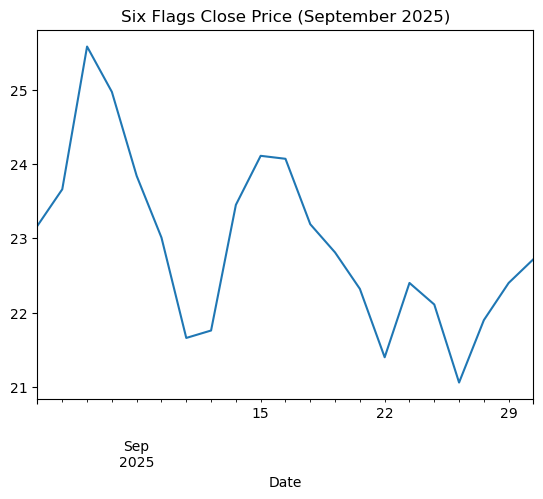

In [49]:
# Sort the dataframe index
six_flags = six_flags.sort_index()

# Slice the data for September 2025
six_flags_sep = six_flags["Close"]["2025-09-01":"2025-09-30"]
six_flags_sep.plot(title="Six Flags Close Price (September 2025)")

##### Now, show the plot you drew with the previous step, but with a new figsize, line color, and style

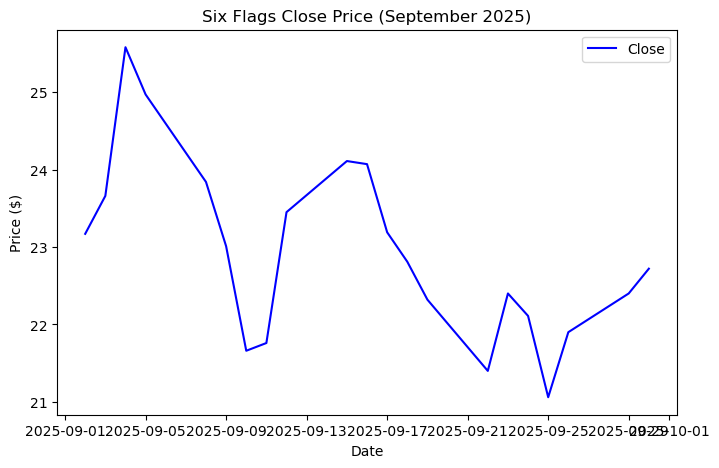

In [50]:
plt.figure(figsize=(8, 5))
plt.plot(six_flags_sep.index, six_flags_sep, color='blue', label='Close')
plt.title("Six Flags Close Price (September 2025)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

This chart shows Six Flags’ closing stock price throughout September 2025, fluctuating between roughly \\$21 and \\$26. The overall movement appears choppy, with no clear upward or downward trend, suggesting short-term volatility rather than directional momentum during that month.

#### Rolling windows
#### Generate a 20-period moving average for your ‘Close’ variable, and create a plot that overlays this 20-period average atop the actual daily closing prices.

In [51]:
six_flags["moving_avg_20"] = six_flags["Close"].rolling(window=20).mean()
six_flags.tail()

,Close,Volume,Open,High,Low,daily_change,moving_avg_20
Date,,,,,,,
2025-11-10,16.35,7033631,17.91,17.985,16.2200,0.91,22.2870
2025-11-11,15.44,7981932,16.23,16.245,14.8050,-0.71,21.9905
2025-11-12,16.15,6184328,15.63,16.550,15.5665,1.09,21.7680
2025-11-13,15.06,4082496,16.40,16.840,15.0400,0.46,21.4580
2025-11-14,14.60,4632733,14.93,15.110,14.1300,NaN,21.1440


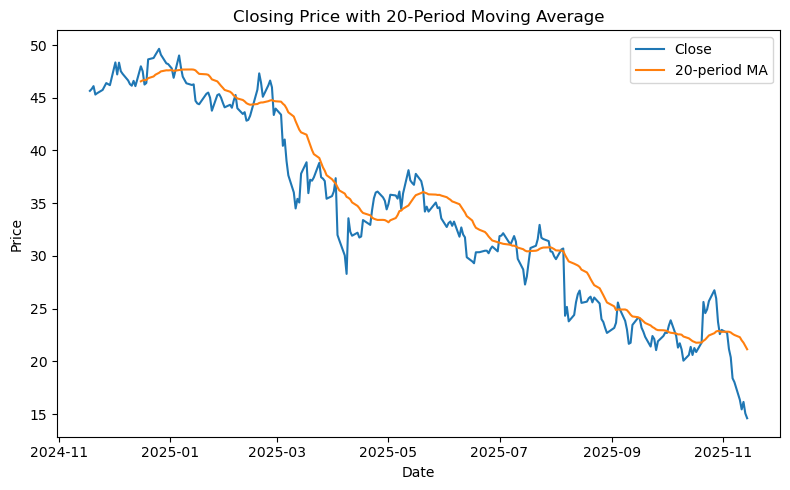

In [52]:
plt.figure(figsize=(8,5))
plt.plot(six_flags["Close"], label="Close")
plt.plot(six_flags["moving_avg_20"], label="20-period MA")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Price with 20-Period Moving Average")
plt.tight_layout()
plt.show()

#### Next, generate a 75-period moving average for your ‘Close’ variable, and create a plot that overlays this 75-period average atop the actual daily closing prices.

In [53]:
six_flags["moving_avg_75"] = six_flags["Close"].rolling(window=75).mean()
six_flags.tail()

,Close,Volume,Open,High,Low,daily_change,moving_avg_20,moving_avg_75
Date,,,,,,,,
2025-11-10,16.35,7033631,17.91,17.985,16.2200,0.91,22.2870,23.840800
2025-11-11,15.44,7981932,16.23,16.245,14.8050,-0.71,21.9905,23.628000
2025-11-12,16.15,6184328,15.63,16.550,15.5665,1.09,21.7680,23.437600
2025-11-13,15.06,4082496,16.40,16.840,15.0400,0.46,21.4580,23.233333
2025-11-14,14.60,4632733,14.93,15.110,14.1300,NaN,21.1440,23.028533


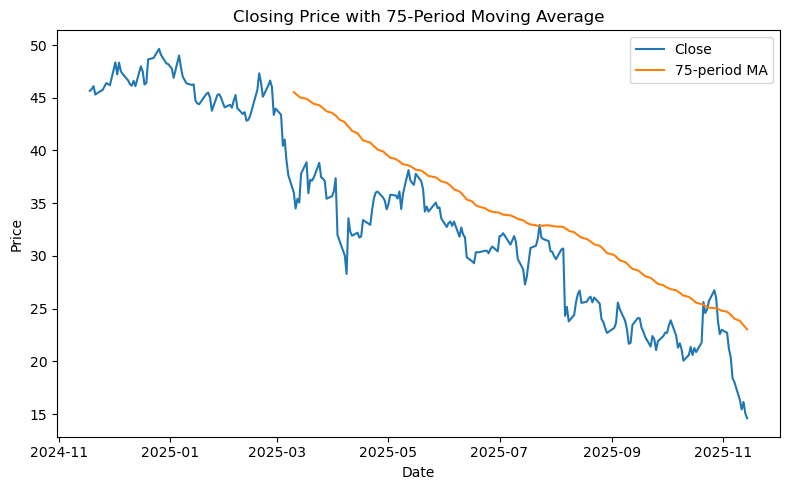

In [54]:
plt.figure(figsize=(8,5))
plt.plot(six_flags["Close"], label="Close")
plt.plot(six_flags["moving_avg_75"], label="75-period MA")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Price with 75-Period Moving Average")
plt.tight_layout()
plt.show()

#### How are your two moving average plots different from one another? What are some pros and cons of shorter and longer moving average windows?
The two moving average plots differ in the length of the window used to smooth the closing price data. The 20-period moving average reacts quickly to short-term fluctuations and closely follows the daily ups and downs, making it more jagged. The 75-period moving average smooths out more noise, highlighting the broader trend over time, but it lags behind recent price movements and adjusts more slowly.

Shorter windows like 20 periods are helpful for spotting short-term momentum and quick shifts in direction, though they can be sensitive to noise and produce false signals. Longer windows like 75 periods are better for identifying long-term trends and filtering out daily volatility, but they respond more slowly, which can delay recognition of turning points.

#### Plot a rolling standard deviation for your time series data.

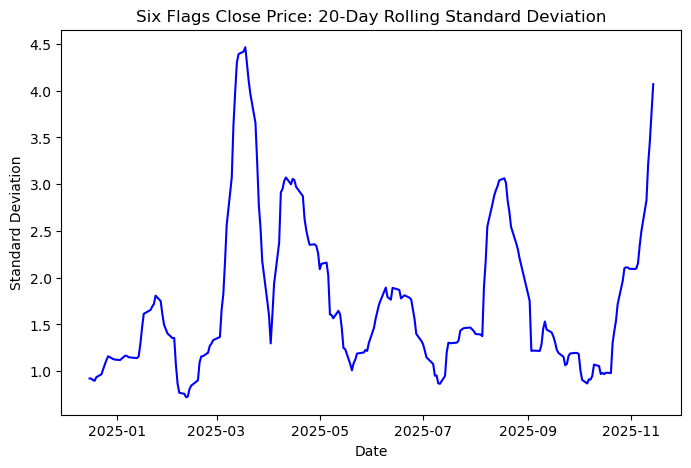

In [55]:
# Create rolling standard deviation (20-day window)
six_flags["rolling_std_20"] = six_flags["Close"].rolling(window=20).std()

plt.figure(figsize=(8, 5))
plt.plot(six_flags.index, six_flags["rolling_std_20"], color='blue')
plt.title("Six Flags Close Price: 20-Day Rolling Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.show()

#### What does your rolling standard deviation plot show you about your time series?
The rolling standard deviation plot for ‘Close’ prices shows how the Six Flags’ stock volatility changed throughout 2025. Using a 20-day window, the graph highlights peaks and troughs, with spikes in mid-2025 indicating periods of higher uncertainty, and lower stretches where volatility drops closer to 1.

These bursts of volatility correspond to real-world events. In Q2 2025, Six Flags reported a net loss due to adverse weather and merger-related challenges, and in Q3 2025, the company recorded a large non-cash impairment charge. Such events likely caused rapid day-to-day price movements, explaining the spikes seen in the rolling standard deviation. Overall, the plot shows that the stock’s decline was not smooth or predictable. High-volatility periods meant greater uncertainty for investors, while low-volatility stretches offered more stable performance, providing a clearer picture of risk throughout the year.

**References:** https://www.tipranks.com/news/company-announcements/six-flags-reports-q2-2025-earnings-amid-weather-challenges

#### Resampling.
#### Resample your time series so that its values are based on quarterly time periods’ mean values for ‘Close’, rather than daily periods.

In [56]:
# Resample the 'Close' column to quarterly frequency and calculate the mean
six_flags_closeq = six_flags['Close'].resample('QE').mean()
six_flags_closeq.head()

Date
2024-12-31    47.097333
2025-03-31    42.545333
2025-06-30    33.510484
2025-09-30    26.555937
2025-12-31    21.339091
Freq: QE-DEC, Name: Close, dtype: float64

##### Plot this newly-resampled time series, with the dates on the x-axis, and the Close values on the y-axis.

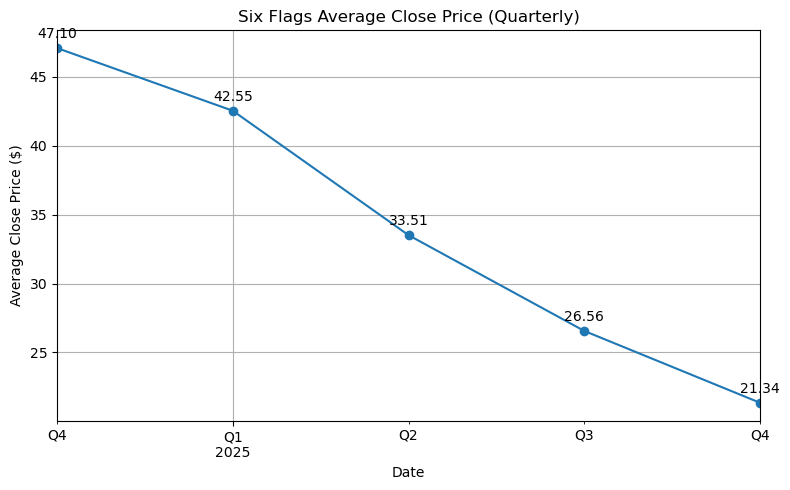

In [57]:
plt.figure(figsize=(8, 5))
six_flags_closeq.plot(marker='o')
plt.title('Six Flags Average Close Price (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Average Close Price ($)')
plt.grid(True)
# Annotate the data points
for date, value in zip(six_flags_closeq.index, six_flags_closeq.values):
    plt.text(date, value + 0.5, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

This chart shows a steady decline in Six Flags’ average closing stock price over five consecutive quarters, falling from \\$47.10 in late 2024 to \\$21.34 by Q4 2025, with the steepest drop between Q1 and Q2 of 2025. By using quarterly averages, the chart smooths out daily fluctuations and highlights the overall trend more clearly. This makes it easier to see sustained downward pressure on the stock and identify periods of significant change.

##### Provide an example that explains why someone might care about resampling a time series.
A retail analyst tracking daily sales at a chain of toy stores can see a lot of fluctuations in the raw data. Resampling the data into weekly or monthly averages makes it easier to compare different periods, such as the holiday season or Black Friday versus regular months. For example, December and the week of Black Friday consistently show higher average sales than other months, helping the business plan inventory, staffing, and promotions more effectively. By smoothing out daily noise, resampling provides a clearer picture of these seasonal patterns and supports smarter operational decisions.

## Part II: Marketing Mix Modeling with an Interaction Term

#### After reading the file into your environment, the first question that you will explore here is whether there is any relationship between marketing spending and conversions.

In [58]:
lobster_campaign = pd.read_csv("/Users/nhattran/Downloads/MSBA/METAD654 - Marketing Analytics/assignment 5/marketing_campaign_lobster.csv")
lobster_campaign.head()

,influencer_spend,email_spend,radio_spend,conversions
0,28.97,62.85,28.73,45
1,134.30,61.11,74.28,194
2,140.56,9.43,33.48,100
3,72.38,21.88,76.27,73
4,64.35,81.06,49.26,112


#### To explore this, first create a new variable that shows the total spending. This variable’s value should be the sum of influencer_spend, email_spend, and radio_spend.

In [59]:
lobster_campaign["total_spending"] = lobster_campaign[["influencer_spend", "email_spend", "radio_spend"]].sum(axis=1)
lobster_campaign.head()

,influencer_spend,email_spend,radio_spend,conversions,total_spending
0,28.97,62.85,28.73,45,120.55
1,134.30,61.11,74.28,194,269.69
2,140.56,9.43,33.48,100,183.47
3,72.38,21.88,76.27,73,170.53
4,64.35,81.06,49.26,112,194.67


#### Now, find the correlation between this new total spending variable and conversions.

In [60]:
lobster_campaign_corr = lobster_campaign["total_spending"].corr(lobster_campaign["conversions"])
print(f"The correlation between total spending and conversions: {lobster_campaign_corr:.4f}")

The correlation between total spending and conversions: 0.8832


##### What is the correlation between these variables?
The correlation between total marketing spending (sum of influencer, email, and radio spend) and conversions is 0.8832, which indicates a strong positive relationship.

##### What does this correlation suggest about the relationship between total marketing spending and conversion?
This strong correlation shows that higher total marketing spending is generally associated with more conversions. In other words, when more is invested in advertising, the dataset suggests conversion numbers tend to be higher.

##### Why can't we conclude from this that more ad spending leads to more conversions?
However, this does not prove that higher ad spending directly causes more conversions. Other factors, such as seasonality, product quality, or external events, could be influencing both spending and results. Without testing the relationship through a controlled experiment or using a causal model, it is impossible to determine whether higher ad spending actually drives more conversions or if other factors are the main reason.

#### Next, let’s explore the relationship among the influencer ad spending, email ad spending, and radio ad spending variables. Examine the correlations among these three variables.

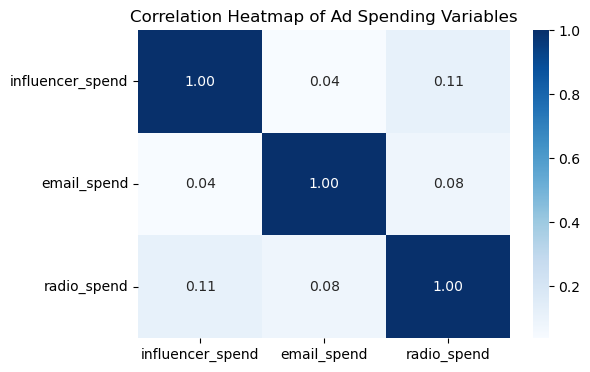

In [61]:
# Compute correlation matrix for the three spending variables
corr_matrix = lobster_campaign[['influencer_spend','email_spend','radio_spend']].corr()

# Plot the heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap of Ad Spending Variables")
plt.show()

##### Are any of these correlations so high that we might not be able to use them together in a linear model?
None of the ad spending variables are highly correlated, so multicollinearity is not a concern for a linear model. The highest correlation is only 0.11 between influencer and radio spend, which is very low. This means each variable gives mostly separate information, so they can be used together in a regression without messing up the results.

#### Now, build a model that uses conversions as the outcome variable, with influencer spending, email ad spending, and radio ad spending as the input variables. 

In [62]:
# Define predictors (X) and outcome (y)
X = lobster_campaign[['influencer_spend', 'email_spend', 'radio_spend']]
y = lobster_campaign['conversions']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            conversions   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     449.0
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           1.80e-73
Time:                        00:23:16   Log-Likelihood:                -679.66
No. Observations:                 150   AIC:                             1367.
Df Residuals:                     146   BIC:                             1379.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -72.2859      6.100  

##### What's the p-value and the F-statistic for this model? What does this suggest about the model?
The F-statistic for the model is 449.0, with a p-value of 1.80e-73, which is extremely small. This indicates that the overall model is statistically significant, meaning at least one of the predictors meaningfully explains variation in conversions and the model does a good job fitting the data.

##### What are the p-values for each of the individual predictors used in this model? What does this suggest about these predictors?
Looking at the individual predictors, influencer spend and email spend both have p-values of 0.000, showing they are significant contributors to conversions. Radio spend, on the other hand, has a p-value of 0.430, which is not significant. This suggests that radio spend does not have a meaningful effect on conversions in this model and may not be as helpful as other variables with prediction.

#### Lobster Land's marketing team is investigating how different types of advertising spend impact the number of conversions. They need you to create an interaction plot to visualize the relationship between influencer_spend and conversions, across different levels of email_spend.
##### First, create a new variable called email_spend_group by dividing email_spend into three groups: low, medium, and high.

In [63]:
lobster_campaign['email_spend_group'] = pd.qcut(
    lobster_campaign['email_spend'],
    q=3,
    labels=['Low','Medium','High']
)

print(lobster_campaign[['email_spend','email_spend_group']])

     email_spend email_spend_group
0          62.85            Medium
1          61.11            Medium
2           9.43               Low
3          21.88               Low
4          81.06              High
..           ...               ...
145        24.52               Low
146        68.60            Medium
147         9.64               Low
148        57.53            Medium
149        31.74               Low

[150 rows x 2 columns]


##### Then, plot conversions against influencer_spend, using different colored lines for each email_spend_group.
##### Use seaborn.lmplot() or something similar to draw trend lines for each group.

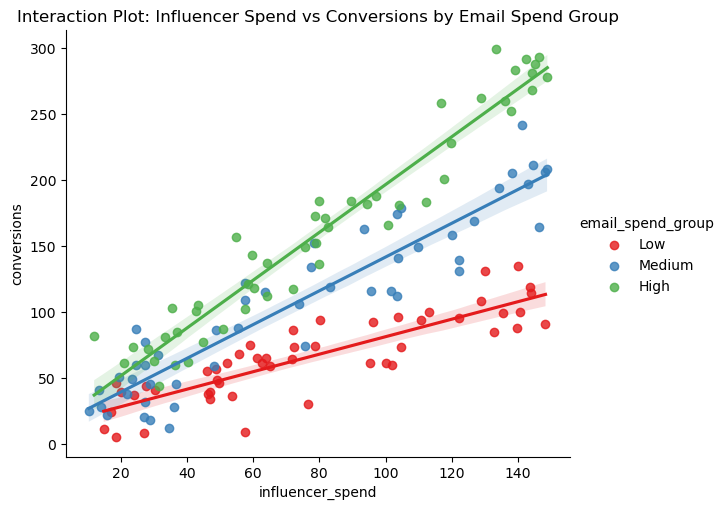

In [64]:
sns.lmplot(
    data=lobster_campaign,
    x='influencer_spend',
    y='conversions',
    hue='email_spend_group',
    height=5,
    aspect=1.2,
    palette='Set1'
)
plt.title("Interaction Plot: Influencer Spend vs Conversions by Email Spend Group")
plt.show()

##### What đo the different slopes tell you? Is there visual evidence of an interaction between influencer_spend and email_spend? How would the lines appear if there were no interaction? 
The different slopes show that the effect of influencer spend on conversions depends on the level of email spend. For instance, the green "High" group has the steepest slope, meaning influencer marketing drives the most conversions when email spend is also high. The red "Low" group has a much flatter slope, indicating that influencer spend is less effective at lower levels of email spend.

There is visual evidence of an interaction because the lines diverge rather than staying parallel, showing that the impact of influencer spend varies with email spend. If there were no interaction, the lines would be roughly parallel, indicating that influencer spend affects conversions the same way regardless of email spending level. The vertical position of each line might differ (due to additive effects), but the slopes would be similar.

#### Build yet another model -- this time, you will again use conversions as the outcome variable. Your inputs will be influencer ad spending, email ad spending, and an interaction variable for influencer ad spending & email ad spending.

In [65]:
# Create an interaction variable for influencer ad spendinng and email ad spending
lobster_campaign['interaction'] = (lobster_campaign['influencer_spend'] * lobster_campaign['email_spend'])
print(lobster_campaign[['influencer_spend','email_spend','interaction']])

     influencer_spend  email_spend  interaction
0               28.97        62.85    1820.7645
1              134.30        61.11    8207.0730
2              140.56         9.43    1325.4808
3               72.38        21.88    1583.6744
4               64.35        81.06    5216.2110
..                ...          ...          ...
145             18.67        24.52     457.7884
146             57.64        68.60    3954.1040
147             78.77         9.64     759.3428
148            119.89        57.53    6897.2717
149             14.93        31.74     473.8782

[150 rows x 3 columns]


In [66]:
# Define predictors (X) and outcome (y)
X = lobster_campaign[['influencer_spend', 'email_spend', 'interaction']]
y = lobster_campaign['conversions']

X = sm.add_constant(X)
model_interaction = sm.OLS(y, X).fit()
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:            conversions   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1011.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           2.03e-97
Time:                        00:23:17   Log-Likelihood:                -622.98
No. Observations:                 150   AIC:                             1254.
Df Residuals:                     146   BIC:                             1266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.4199      6.480  

##### What do you notice about the p-values for each of these predictors?
In the interaction model, all three predictors are statistically significant. Influencer spend has a positive effect on conversions (coef = 0.4262, p = 0.000), and email spend also contributes meaningfully (coef = 0.3122, p = 0.004). The interaction term is positive and highly significant (coef = 0.0147, p = 0.000), showing that conversions are not driven by either channel on its own. Instead, the two variables complement with each other, and the impact of influencer marketing becomes stronger when email marketing spend is higher. This combined effect definitely improves performance.

##### How does the R-squared of this model compared to the R-squared of the model built to predict conversions, but with only influencer speding and email ad spending, but without the interaction?
The model with the interaction term explains about 95 percent of the variation in conversions (R² = 0.954). In comparison, the model without the interaction shows about 90 percent (R² = 0.902). Both models perform well, but the interaction model captures the data more effectively. The increase in R² indicates that adding the interaction term provides meaningful predictive value and offers a more realistic view of how the marketing team at Lobster Land would optimize their budget.

##### Demonstrate what your model would predict for a marketer using 100 units of influencer ad spending and 50 units of email ad spending. What conversions outcome should this marketer expect to see?

$$
\text{conversions} = \beta_0 
+ \beta_1 \cdot \text{influencer\_spend} 
+ \beta_2 \cdot \text{email\_spend} 
+ \beta_3 \cdot (\text{influencer\_spend} \times \text{email\_spend})
$$

Whereas, the coefficients are:
- Intercept ($\beta_0$) = -1.4199  
- Influencer spend ($\beta_1$) = 0.4262  
- Email spend ($\beta_2$) = 0.3122  
- Interaction ($\beta_3$) = 0.0147

And given the Influencer spend = 100; Email spend = 50
- Interaction = 100 × 50 = 5000


The predicted conversion is:
$$
\text{conversions} = -1.4199 
+ (0.4262 \times 100) 
+ (0.3122 \times 50) 
+ (0.0147 \times 5000)
$$

$$
= -1.4199 + 42.62 + 15.61 + 73.5
$$

$$
= 130.3
$$

This prediction translates the regression results into a practical forecast: with 100 units of influencer spend and 50 units of email spend, the team should expect about 131 conversions. The interaction term alone contributes roughly 73.5 of these conversions, which is more than the individual contributions from influencer or email spend. This shows that the combined effect of the two channels is a major driver of total conversions.

The interaction effect shows that influencer spend becomes more effective when it is paired with an increase in email spend. Instead of operating independently, the two channels complement one another, meaning the impact of influencer campaigns increases when email marketing is also strong. For Lobster Land, this suggests that bundling influencer and email efforts will produce better conversion outcomes than investing in either channel on its own. One suggestion is that Lobster Land could boost results by running influencer promotions that drive users to sign up for an email offer, then following up with targeted emails that convert that traffic into purchases.